# TO-DO

- Plot class imbalance plot
- Neural network implementation
- Cross validation
- Third model?

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

from scipy import stats

import os
import shutil
from tqdm import tqdm

import cv2
from PIL import Image

In [2]:
# Fix seed
np.random.seed(0)

## Dataset Preparation

In [2]:
current_dir = os.getcwd()
face_dir = os.path.join(current_dir, "dataset", "cmu+face+images", "faces", "faces")

In [3]:
# Create dictionary based on face orientation
data_dict = {"left": [],
             "right": [],
             "straight": [],
             "up" : []}

for human in os.listdir(face_dir):
    if not human.startswith("."):
        for image in os.listdir(os.path.join(face_dir, human)):
            if (not image.endswith(".bad")) and (not image.endswith("2.pgm")) and (not image.endswith("4.pgm")):
                key = image.split("_")[1]
                data_dict[key].append(os.path.join(face_dir, human, image))

In [4]:
# Create folders with respective labels
orient_folder = "face_orientation"

location = os.path.join(current_dir, "dataset", "cmu+face+images")
if not os.path.exists(os.path.join(location, orient_folder)):
    os.mkdir(os.path.join(location, orient_folder))
face_orientation =  os.path.join(location, orient_folder)

for key in data_dict.keys():
    if not os.path.exists(os.path.join(face_orientation, key)):
        os.mkdir(os.path.join(face_orientation, key))
    path = os.path.join(face_orientation, key)
    for image in data_dict[key]:
        shutil.copy(image, os.path.join(path, os.path.split(image)[-1]))

## Dataset Analysis

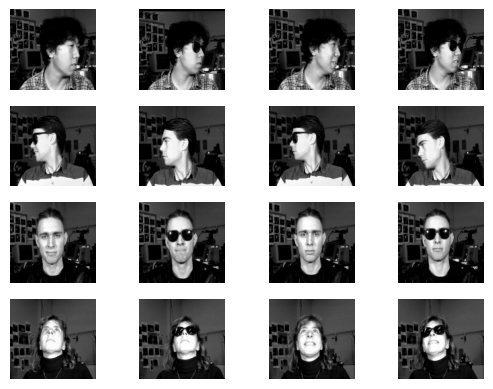

In [3]:
# Check example images
current_dir = os.getcwd()
orient_folder = "face_orientation"
location = os.path.join(current_dir, "dataset", "cmu+face+images")
face_orientation =  os.path.join(location, orient_folder)

# Gather all data
keys = ["left", "right", "straight", "up"]
all_data = [(Image.open(os.path.join(face_orientation, key, image)).convert(mode="L"), key) for key in keys for image in os.listdir(os.path.join(face_orientation, key))]

plt.figure()
for row in range(4):
    for col in range(4):
        plt.subplot2grid((4, 4), (row, col))
        example = all_data[row*200 + col][0]
        plt.imshow(example, cmap="gray")
        plt.axis("off")
plt.show()

In [58]:
all_data[0][0], all_data[0][1]

(<PIL.Image.Image image mode=L size=128x120>, 'left')

In [59]:
X = np.array([elem[0] for elem in all_data]) 
X = X.reshape((len(all_data), -1))/255.0 # (624, 120, 128) --> (624, 15360) and [0, 255] -> [0, 1]

In [60]:
shape = (120, 128)

### Principal Component Analysis

In [61]:
def PCA(data, first_k=90, shape=(120, 128), speak=True):

    center = data.mean(axis= 0)
    centered = data - center # Subtract mean 

    u, s, vt = np.linalg.svd(centered)
    
    lambdas = np.square(s)/(X.shape[0] - 1)

    first_k = 90
    eig_first_k = lambdas[0:first_k]/sum(lambdas)
    preserved = [sum(eig_first_k[0:i+1]) for i in range(first_k)]
    eig_idx = first_k - np.sum(np.array(preserved) >= 0.9)

    if speak:
        plt.figure()
        plt.imshow(center.reshape(shape))
        plt.axis("off")
        plt.title("Mean of the data matrix")

        plt.figure()
        plt.imshow(centered[0].reshape(shape))
        plt.axis("off")
        plt.title("Centered image example")


        # Plot the explained variance ratio
        plt.figure()
        plt.bar(np.linspace(1,first_k,first_k), eig_first_k, label="Variance", color="black")
        plt.xticks(np.linspace(1,first_k,first_k), [x + 1 for x in range(first_k)])
        plt.xticks(np.linspace(0, first_k, 10), [str(num) for num in np.linspace(0, first_k, 10, dtype=int)])
        plt.yticks(np.arange(0.0, 1.0, 0.1), [str(num)[:3] for num in np.arange(0.0, 1.0, 0.1)])
        plt.xlabel("kth largest principal component")
        plt.ylabel("Proportion of variance captured")
        plt.title(f"Proportion of variance captured by the first ten largest principal components \n eig_idx = {eig_idx}")
        plt.plot(np.linspace(1,first_k,first_k), preserved, label="Cumulative Variance", color="blue")
        plt.axhline(y=0.9, color="red", label="90% Variance")
        plt.legend()
        plt.grid()

        # Plot first 16 principal components
        plt.figure()
        plotdim = 4
        plt.title(f"First {plotdim**2} principal components")
        for row in range(plotdim):
            for col in range(plotdim):
                plt.subplot2grid((plotdim, plotdim), (row, col))
                plt.imshow(X=vt[plotdim*row + col].reshape(shape))
                plt.axis("off")
        
        plt.show()

    return center, lambdas, vt, eig_idx

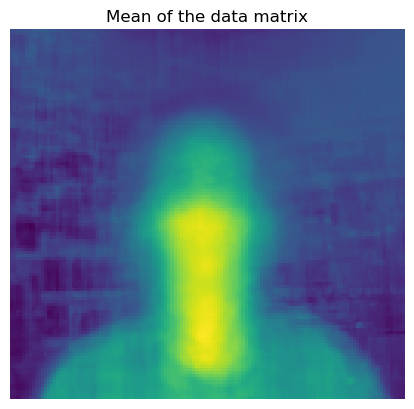

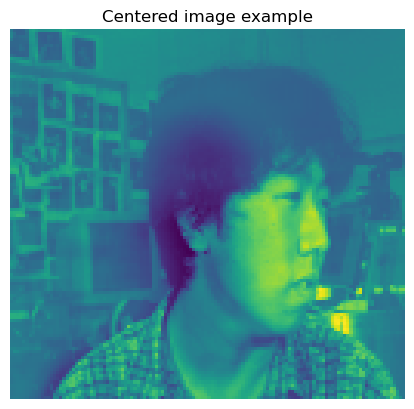

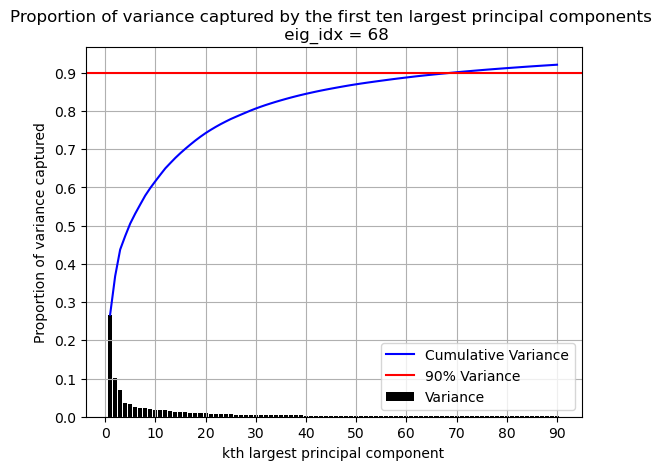

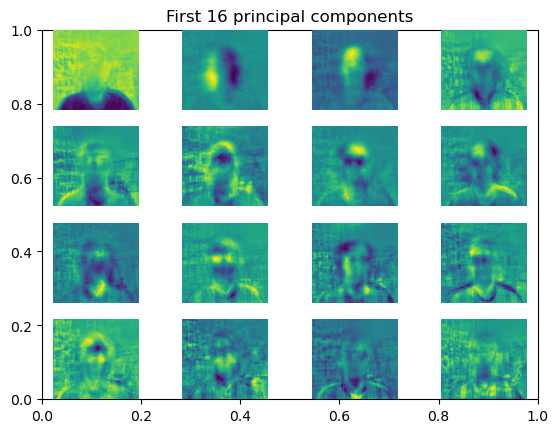

In [62]:
center, lambdas, vt, eig_idx = PCA(X)

In [63]:
# Compute coefficients and reconstruct image
coeffs = X[0].reshape((1, -1)) @ vt[:eig_idx].T
recon = coeffs @ vt[:eig_idx]

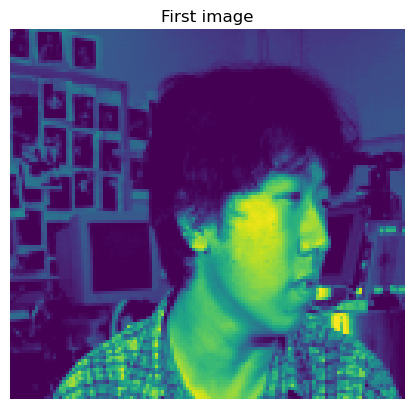

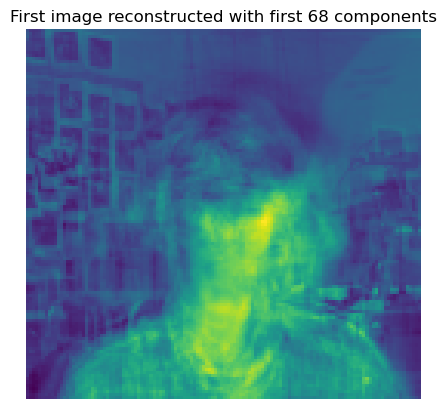

In [64]:
plt.imshow(X[0].reshape(shape))
plt.axis("off")
plt.title("First image")
plt.show()

plt.imshow((recon + center).reshape(shape))
plt.axis("off")
plt.title(f"First image reconstructed with first {eig_idx} components")
plt.show()

### Non-negative Matrix Factorization

In [44]:
def NNMF(data, shape=(120, 128), embedding_size=64, iterations=1000):

    nnmf_scaler = np.sqrt(np.mean(data)/data.shape[0])
    nnmf_loss = []

    # Initialize non-negative matrices
    W = abs(np.random.standard_normal((X.shape[0], embedding_size)))*nnmf_scaler
    H = abs(np.random.standard_normal((embedding_size, X.shape[-1])))*nnmf_scaler

    for iteration in tqdm(range(iterations)):
        W_numerator = np.matmul(X, H.T)
        W_denominator = np.matmul(np.matmul(W, H), H.T)
        W_alpha = np.divide(W_numerator, W_denominator)
        
        W = W*W_alpha
        
        H_numerator = np.matmul(W.T, X)
        H_denominator = np.matmul(np.matmul(W.T, W), H)
        H_alpha = np.divide(H_numerator, H_denominator)
        
        H = H*H_alpha
        
        nnmf_loss.append(np.linalg.norm(X - np.matmul(W, H), "fro"))
    
    return W, H, nnmf_loss

In [45]:
W, H, nnmf_loss = NNMF(X)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [02:58<00:00,  5.60it/s]


Text(0, 0.5, 'Loss')

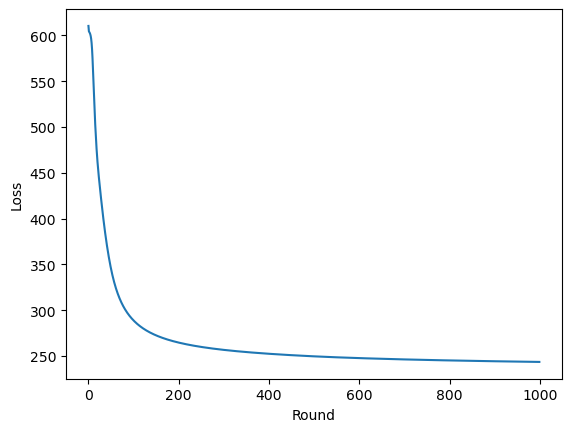

In [46]:
plt.figure()
plt.plot(nnmf_loss)
plt.xlabel("Round")
plt.ylabel("Loss")

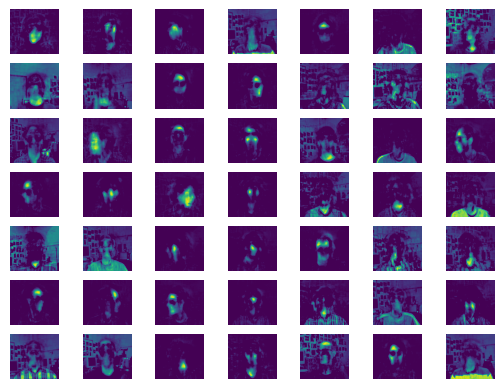

In [51]:
#Plot NMF-faces
plt.figure()
plot_dim = 7
for i in range(plot_dim):
    for j in range(plot_dim):
        plt.subplot(plot_dim, plot_dim, plot_dim*i + j + 1)
        plt.imshow(H[plot_dim*i + j,:].reshape(shape))
        plt.axis("off")

In [48]:
# Obtain mixing coefficients for the first 6 people, NMF
coeff_six_images_nmf = W[0:6,:].reshape(6, -1)

In [49]:
# Reconstruct the first 6 images, NMF
recon_six_images_nmf = np.matmul(coeff_six_images_nmf, H)

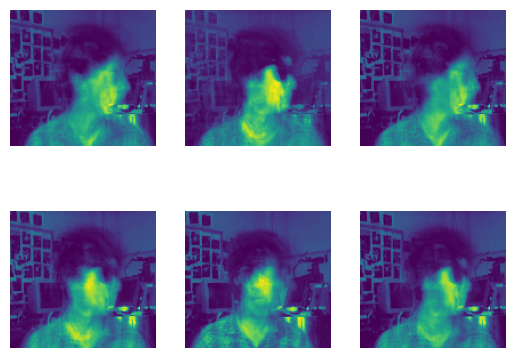

In [52]:
# Plot the first 6 reconstructed faces, NMF
plt.figure()
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(recon_six_images_nmf[i,:].reshape(shape))
    plt.axis("off")

### JL Transform (Random Projections)

In [52]:
jl_error = 0.5
jl_bound = 24*np.log(X.shape[-1])/(3*jl_error**2 - 2*jl_error**3)
print(f"Minimum dimension for random projection {jl_bound}")

Minimum dimension for random projection 462.69705632167984


In [53]:
random_proj_matrix = np.random.multivariate_normal(np.zeros(int(jl_bound)), np.eye(int(jl_bound))/jl_bound**2)

In [54]:
random_proj_matrix = np.random.normal(loc=0, scale=1/jl_bound, size=(X.shape[-1], int(jl_bound)))

In [55]:
random_proj_matrix.shape

(15360, 462)

In [56]:
random_proj_coeffs = X[0].reshape((1, -1)) @ random_proj_matrix
random_proj_recon = random_proj_coeffs @ random_proj_matrix.T

## Classification

In [211]:
def sample_no_replacement(arr, num):
    np.random.shuffle(arr)
    x, arr = arr[:num], arr[num:]
    return x, arr

In [212]:
def create_train_test(data, labels, train_split=80):
    assert(0 <= train_split <= 100)

    train_data, train_labels = [], []
    test_data, test_labels = [], []
    targets = np.array([m[-1] for m in data])
    for label in labels.keys():
        points = np.array([data[i][0] for i in (targets == label).nonzero()[0]])
        train, test = sample_no_replacement(points, len(points)*train_split//100)
        train_data.append(train)
        test_data.append(test)
        for i in range(len(train)):
            train_labels.append(label)
        for i in range(len(test)):
            test_labels.append(label)
    
    train_data = np.concatenate(train_data)
    train_data = train_data.reshape(train_data.shape[0], -1)/255.0
    train_labels = np.array([labels[elem] for elem in train_labels])
    test_data = np.concatenate(test_data)
    test_data = test_data.reshape(test_data.shape[0], -1)/255.0
    test_labels = np.array([labels[elem] for elem in test_labels])

    return train_data, train_labels, test_data, test_labels

In [213]:
labels = {"left": 0, "right": 1, "straight" : 2, "up": 3}

In [214]:
train_data, train_labels, test_data, test_labels = create_train_test(all_data, labels)

### KNN

In [222]:
_, _, vt, eig_idx = PCA(train_data, speak=False)

In [223]:
# Prepare train and test embeddings through PCA
train_embeddings = train_data.reshape((train_data.shape[0], -1)) @ vt[:eig_idx].T
test_embeddings = test_data.reshape((test_data.shape[0], -1)) @ vt[:eig_idx].T

In [235]:
def KNN(train_embeddings, train_labels, test_embeddings, test_labels, k=3, speak=True):

    assert(k > 0)

    knn_confusion_matrix = np.zeros(shape=[len(labels)]*2)

    for data, label in zip(test_embeddings, test_labels):

        distances = np.linalg.norm(train_embeddings - data, axis=1)
        neighbors = np.sort(distances)[:k]
        preds = []

        for neighbor in neighbors:
            pred_idx = np.where(distances == neighbor)
            preds.append(train_labels[pred_idx][0])
        prediction = stats.mode(preds).mode
        
        knn_confusion_matrix[label, prediction] += 1

    knn_accuracy = knn_confusion_matrix.trace()/knn_confusion_matrix.sum()

    if speak:
        print(f"{k}-KNN accuracy: {knn_accuracy}")

        plt.figure()
        sns.heatmap(knn_confusion_matrix, annot=True, cbar=False, xticklabels=labels.keys(), yticklabels=labels.keys(), cmap="YlGnBu")
        plt.xlabel("Predicted")
        plt.ylabel("Ground truth")
        plt.title(f"{k}-KNN confusion matrix")
        plt.show()
    
    return knn_accuracy, knn_confusion_matrix

1-KNN accuracy: 0.9448818897637795


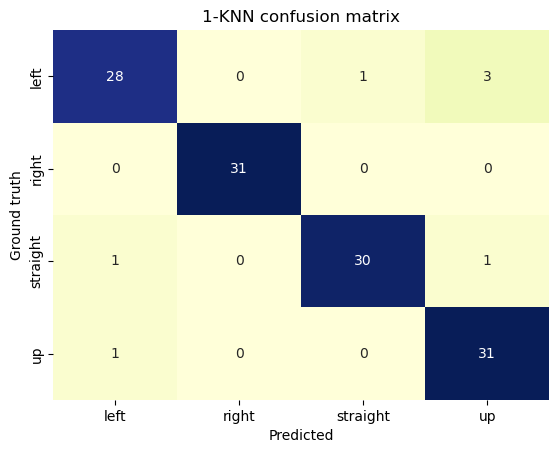

(0.9448818897637795,
 array([[28.,  0.,  1.,  3.],
        [ 0., 31.,  0.,  0.],
        [ 1.,  0., 30.,  1.],
        [ 1.,  0.,  0., 31.]]))

In [242]:
k = 1
KNN(train_embeddings, train_labels, test_embeddings, test_labels, k)

### Neural Network

In [1]:
import numpy as np
from neural_network.layer import *
from queue import Queue
import matplotlib.pyplot as plt

In [7]:
x_input = np.ones((10, 1))
y_target = np.array([[0.5], [0.5]])
linear1 = Linear(10, 5)
relu1 = ReLU(linear1)
linear2 = Linear(5, 2, relu1)
relu2 = ReLU(linear2)
linear3 = Linear(2, 2, relu2)
sigmoid = Sigmoid(linear3)
loss_layer = MSE_Loss(sigmoid)

In [4]:
def forward_pass(x_input, first_layer):
    queue = Queue()
    node = first_layer
    node_input = x_input
    node.forward(node_input)

    for child in node.children:
        queue.put(child)

    while not queue.empty():
        node = queue.get()
         
        node.forward(node_input)

        for child in node.children:
            if not issubclass(type(child), Loss):
                queue.put(child)
    
    return node.out

In [5]:
def backward_pass(loss_layer):
    queue = Queue()
    queue.put(loss_layer)

    while not queue.empty():
        node = queue.get()
        # print(node)

        node.backward()
        node.update(0.01)
        # update here
        for parent in node.parents:
            queue.put(parent)

In [10]:
loss_array = []
for i in range(10000):
    out = forward_pass(x_input, linear1)
    print(out)
    loss = loss_layer.forward(out, y_target)
    loss_array.append(loss)
    backward_pass(loss_layer)

[[0.80966051]
 [0.38032559]]
[[0.7966308 ]
 [0.37813287]]
[[0.78347782]
 [0.37603004]]
[[0.77029355]
 [0.37402059]]
[[0.75716942]
 [0.37210732]]
[[0.74419332]
 [0.37029219]]
[[0.73144692]
 [0.36857631]]
[[0.7190035 ]
 [0.36695992]]
[[0.70692638]
 [0.36544238]]
[[0.69526808]
 [0.36402228]]
[[0.68406994]
 [0.36269748]]
[[0.67336248]
 [0.36146524]]
[[0.66316603]
 [0.36032234]]
[[0.65349172]
 [0.35926514]]
[[0.64434267]
 [0.35828975]]
[[0.63571518]
 [0.3573921 ]]
[[0.6276  ]
 [0.356568]]
[[0.61998346]
 [0.35581326]]
[[0.61284852]
 [0.35512372]]
[[0.60617571]
 [0.35449533]]
[[0.5999439 ]
 [0.35392413]]
[[0.59413096]
 [0.35340633]]
[[0.58871429]
 [0.3529383 ]]
[[0.58367128]
 [0.35251662]]
[[0.57897958]
 [0.35213802]]
[[0.57461739]
 [0.35179945]]
[[0.57056366]
 [0.35149801]]
[[0.56679816]
 [0.35123104]]
[[0.56330161]
 [0.350996  ]]
[[0.56005572]
 [0.35079056]]
[[0.55897679]
 [0.35083534]]
[[0.55890783]
 [0.35099648]]
[[0.55883895]
 [0.35115749]]
[[0.55877013]
 [0.35131839]]
[[0.55870139]
 [0.

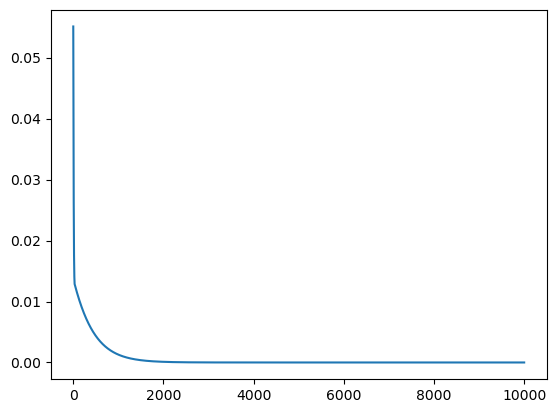

In [11]:
plt.plot(loss_array)

In [2]:
x_input = np.ones((10, 1))
y_target = np.array([[0.5], [0.5]])
linear1 = Linear(10, 5)
relu1 = ReLU(linear1)
linear2 = Linear(5, 2, relu1)
relu2 = ReLU(linear2)
linear3 = Linear(2, 2, relu2)
addition1 = Addition([relu2, linear3])
sigmoid = Sigmoid(addition1)
loss_layer = MSE_Loss(sigmoid)

In [6]:
loss_array = []
for i in range(1000):
    out = forward_pass(x_input, linear1)
    print(out)
    loss = loss_layer.forward(out, y_target)
    loss_array.append(loss)
    backward_pass(loss_layer)

[[0.15895635]
 [0.64805915]]


AttributeError: 'Linear' object has no attribute 'grad'

In [38]:
out = forward_pass(x_input, linear1)

In [40]:
loss_layer.forward(out, y_target)

0.10294523863301265

In [41]:
backward_pass(loss_layer)

[[0.97678775]
 [0.95315744]]
[[1. ]
 [0.5]]


In [25]:
out.out

array([[0.09456909],
       [0.93157761]])

In [16]:
out.out

array([[0.09718889],
       [0.93065274]])

In [17]:
out.out.shape

(2, 1)

In [18]:
y_target = np.array([[1.0], [0.5]])

In [19]:
y_target.shape

(2, 1)

In [20]:
loss_layer = MSE_Loss(out)

In [21]:
loss_layer.parents

In [22]:
loss_layer.forward(out.out, y_target)

0.5002648474102386

In [23]:
queue = Queue()
queue.put(loss_layer)

while not queue.empty():
    node = queue.get()
    print(node)

    node.backward()
    node.update(0.01)
    # update here
    for parent in node.parents:
        queue.put(parent)

[[0.09718889]
 [0.93065274]]
[[1. ]
 [0.5]]


In [30]:
out.grad

AttributeError: 'Sigmoid' object has no attribute 'grad'

array([[-0.1893754 ],
       [ 0.13006494]])

In [17]:
1 - 

array([[-0.61242865],
       [-0.46258667]])

In [3]:
x_input = np.ones((10, 1))

In [15]:
linear1 = Linear(10, 2)
out = Sigmoid(linear1)

In [18]:
deneme = []
deneme.append(out)
parents = out.parents
deneme.extend(parents)
parents = [node.parents for node in parents]
print(parents)

while len(parents) > 0:

    parents = [node.parents for node in parents]
    deneme.extend(parents)
    
    

[[]]


AttributeError: 'list' object has no attribute 'parents'

In [19]:
deneme